In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
import pandas as pd
import xarray as xr
import h5py
from astropy.time import Time
from scipy.interpolate import interp1d

In [3]:
from overcast import readers as rd
from overcast.utils import fn2rgt, datainfo, query_rgt, box_sel

In [86]:
ROI = 'BEAUFORT'
dataroot = Path.home()/'shared/data-overcast'/ROI

# load in data saved by Zheng
track07 = xr.open_dataset(dataroot/'BEA_ATL07_201906.nc')
track09 = xr.open_dataset(dataroot/'BEA_ATL09_201906.nc')

track07.heights[track07.heights > 1000] = float('nan') 
track07.photon_rate[track07.photon_rate > 10000] = float('nan')

In [87]:
def interpolate_track(product1_dt, product1_variable, product2_dt):
    
    # in the case here, we are always interpolating ATL07 to ATL09
    change = interp1d(product1_dt, product1_variable)
    
    dt2_var1 = change(product2_dt)
    
    return dt2_var1

In [88]:
var = ['photon_rate', 'gauss','stype','ssh_flag']
track07_interp = pd.DataFrame()

track07_interp.photon_rate = interpolate_track(track07.dt.values, track07.photon_rate.values, track09.dt.values)
track07_interp.gauss = interpolate_track(track07.dt.values, track07.gauss.values, track09.dt.values)
track07_interp.stype = interpolate_track(track07.dt.values, track07.stype.values, track09.dt.values)
track07_interp.ssh_flag = interpolate_track(track07.dt.values, track07.ssh_flag.values, track09.dt.values)
track07_interp.heights = interpolate_track(track07.dt.values, track07.heights.values, track09.dt.values)

In [89]:
laytop = track09['layer_top'].values
laytop[laytop>20e3] = -100
ctop = laytop.max(axis=1)
laybot = track09['layer_bot'].values
cbot = laybot.min(axis=1)

bbox = [-150,75,-110,78]

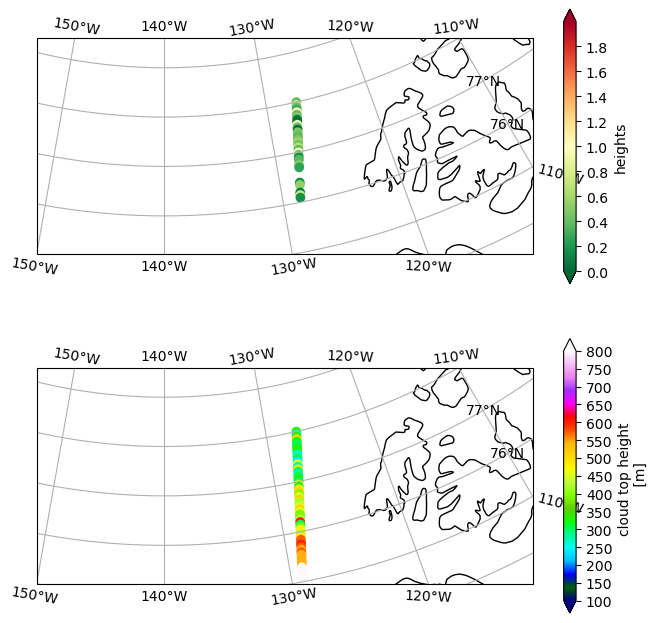

In [90]:
bea_proj = ccrs.NorthPolarStereo(central_longitude=-140)
pcproj   = ccrs.PlateCarree()

fig = plt.figure(1,figsize=(8,8),dpi=100)

vmin = 0; vmax= 2
ticks=np.arange(vmin,vmax,.2)
ax1 = fig.add_subplot(211,projection=bea_proj)
ax1.coastlines(resolution='50m', color='black', linewidth=1)
ax1.set_extent([bbox[0],bbox[2],bbox[1],bbox[3]], pcproj)
ax1.gridlines(draw_labels=True)
# cs = ax1.contour(dsera_cut.lons,dsera_cut.lats,dsera_cut.slp/100,colors='k',transform=pcproj)
# ax1.clabel(cs,cs.levels, inline=True,fontsize=10,fmt='%.1f')
hdl = plt.scatter(track09['lons'][::20],track09['lats'][::20],c=track07_interp.heights[::20], 
            cmap=plt.cm.get_cmap('RdYlGn').reversed(), 
            vmin=vmin,vmax=vmax,
            transform=pcproj)

plt.colorbar(label="heights", shrink=1, ticks=ticks,extend='both');

ax2 = fig.add_subplot(212,projection=bea_proj)
ax2.coastlines(resolution='50m', color='black', linewidth=1)
ax2.set_extent([bbox[0],bbox[2],bbox[1],bbox[3]], ccrs.PlateCarree())
ax2.gridlines(draw_labels=True)
plt.scatter(track09['lons'][::20],track09['lats'][::20],c=ctop[::20], 
            cmap=plt.cm.get_cmap('gist_ncar_r').reversed(), 
            vmin=100,vmax=800,
            transform=pcproj)
plt.colorbar(label='cloud top height \n [m]', shrink=1, ticks=np.arange(100,1000,50),extend='both');

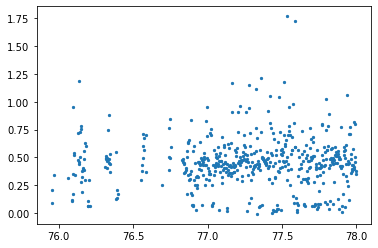

In [91]:
# just a peek at the outliers
plt.scatter(track09.lats,track07_interp.heights, s = 5)


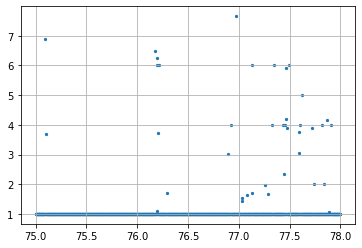

In [97]:
plt.scatter(track09.lats, track07_interp.stype, s =5)
plt.grid()

In [ ]:
whereLeads = track07_interp